In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, invgamma, gamma
from scipy.linalg import sqrtm
from scipy.optimize import minimize
import pandas as pd
from tqdm import tqdm

# Корзина опционов

Пример (Krekel, 2004). В рамках модели Блэка-Шоулза вычислите цены опциона колл на корзину с четырьмя акциями, для которых $T = 5~лет$, безрисковая ставка $r = 0$, корреляция $\rho_{ij} = 0,5$, $\forall i \neq j$, $K = 100$, $F^T_i = 100$, $σ_i = 40\%$ и $w_i = 0,25, i, j = 1, 2, 3, 4$.

Используйте аппроксимацию различными методами
* метод условного математического ожидания (Beisser),
* аппроксимация геометрическим средним (Gentel),
* метод моментов (Levy),
* **метод Джу через разложения в ряд Тейлора** (Ju),
* аппроксимация через обратное геометрическое распределение (MP-RG),
* **метод моментов высших порядков** (MP-4M)

и
сравните полученные аппроксимации с методом Монте-Карло.

In [2]:
T = 5
r = 0
K = 100
N = 4

rho0 = 0.5
rho  = np.ones((N,N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S0   = 100
S    = np.ones(N) * S0
F    = np.ones(N) * S0 * np.exp(r * T)
w    = np.ones(N) / N
q   = np.zeros(N)
sigma = np.ones(N) * 0.4

In [3]:
rho

array([[1. , 0.5, 0.5, 0.5],
       [0.5, 1. , 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 1. ]])

## Аппроксимация геометрическим средним (Gentel)

In [4]:
# аппроксимация корзины опционов геометрическим средним
def geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  a = w * F / np.sum(w * F)

  m_tilde = np.log(np.sum(w * F)) - 0.5 * np.sum(a * sigma ** 2 * T)
  v_tilde = np.sqrt((a * sigma).T @ rho @ (a * sigma) * T)

  K_star =  K - np.sum(w * F) + np.exp(m_tilde + 0.5 * v_tilde ** 2)

  d1 = (m_tilde - np.log(K_star) + v_tilde ** 2) / v_tilde
  d2 = d1 - v_tilde

  basket_call = np.exp(-r * T) * (np.exp(m_tilde + 0.5 * v_tilde ** 2) * norm.cdf(d1) - K_star * norm.cdf(d2))

  return basket_call

In [5]:
geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)

23.783632811454414

## Метод условного математического ожидания (Beisser)

In [6]:
def get_z_star(x, S, K, r, q, sigma, T, w, rho):
    res = 0
    a = S * w * sigma
    sqrt_T = np.sqrt(T)
    sigmaz = np.sqrt(a.T @ rho @ a)
    for i in range(0, len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        exp_S_Z = S[i] * np.exp(sigma[i] * m * x - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        res += w[i] * exp_S_Z
    return (res - K)**2

def Beisser_approximation_basket_call(S, K, T, w, r, q, sigma):
  basket_call = 0
  a = S * w * sigma
  sigmaz = np.sqrt(a.T @ rho @ a)
  sqrt_T = np.sqrt(T)

  z_star = minimize(get_z_star, 0, args=(S, K, r, q, sigma, T, w, rho)).x[0]
  for i in range(0, len(w)):
    m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
    sigma_star = sigma[i] * m * sigmaz / np.sqrt(T)
    K_star = S[i] * np.exp(sigma[i] * m * z_star - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
    S_star = S[i] * np.exp((r - q[i] - 1/2 * sigma_star**2) * T + sigma_star * np.sqrt(T) / sigmaz * z_star)
    d1 = (np.log(S[i] / K_star) + (r - q[i] + 1/2 * sigma_star**2) * T) / (sigma_star * np.sqrt(T))
    d2 = d1 - sigma_star * np.sqrt(T)
    basket_call += w[i] * (np.exp(-q[i] * T) * S[i] * norm.cdf(d1) - np.exp(-r * T) * K_star * norm.cdf(d2))
    return basket_call

In [7]:
Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)

6.908159755754296

## Задача

### Метод Джу через разложения в ряд Тейлора (Ju)

Статья [(Ju, 2002)](https://drive.google.com/file/d/1JJuZhRiCUGf6euyfju1Dn5aRP46-3iry/view?usp=drive_link)

In [8]:
def ju_taylor_approximation_call(S, K, T, sigma, w, rho, r=0):
    """
    Ju's Taylor approximation for basket call option pricing.
    Args:
        S: np.array of spot prices.
        K: Strike price.
        T: Time to maturity.
        sigma: np.array of volatilities.
        w: np.array of weights.
        rho: Correlation matrix.
        r: Risk-free interest rate.

    Returns:
        basket_call: Approximated price of the basket call option.
    """
    N = len(S)
    F = S * np.exp(r * T)
    a = w * F / np.sum(w * F)

    # First two moments of the basket
    mu = np.log(np.sum(w * F)) - 0.5 * np.sum(a * sigma ** 2 * T)
    var = (a * sigma).T @ rho @ (a * sigma) * T

    # Taylor series expansion around zero correlation
    gamma = np.sum(a * sigma) ** 2 / var
    delta = np.sum(a * sigma ** 3) / np.sum(a * sigma ** 2)

    # Adjusted parameters for Ju's approximation
    mu_adjusted = mu - gamma / 2
    sigma_adjusted = np.sqrt(var - delta ** 2 / 3)

    # Black-Scholes formula for approximated parameters
    d1 = (mu_adjusted - np.log(K) + sigma_adjusted ** 2) / sigma_adjusted
    d2 = d1 - sigma_adjusted

    basket_call = np.exp(-r * T) * (
        np.exp(mu_adjusted + 0.5 * sigma_adjusted ** 2) * norm.cdf(d1) - K * norm.cdf(d2)
    )
    return basket_call

# Пример использования:
ju_price = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
print(f"Цена опциона методом Джу: {ju_price:.2f}")

Цена опциона методом Джу: 10.79


## Метод моментов (Log-normal moment matching, Levy’s matching)

In [9]:
def Levy_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  m = 2 * np.log(M) - 1/2 * np.log(V2)
  v = np.sqrt(np.log(V2) - 2 * np.log(M))
  d1 = (m - np.log(K) + v**2) / v
  d2 = d1 - v
  basket_call = np.exp(-r * T) * (M * norm.cdf(d1) - K * norm.cdf(d2))
  return basket_call

In [10]:
Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)

28.051966214249894

## Аппроксимация через обратное геометрическое распределение (MP-RG)

In [11]:
def Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  alpha = (2 * V2  - M**2) / (V2 - M**2)
  beta = (V2 - M**2) / (V2 * M)
  g1 = gamma.cdf(1/K, a = alpha - 1, scale = beta)
  g2 = gamma.cdf(1/K, a = alpha, scale = beta)
  basket_call = np.exp(-r * T) * (M * g1 - K * g2)
  return basket_call

In [12]:
Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)

24.495775089623557

## Задача

### Метод моментов высоких порядков (MP-4M)

Статья [(Posner and Milevsky, 1998)](https://https://drive.google.com/file/d/16f5dRiA_HD9jhm-esUT_6gGoArk9Nc2u/view?usp=drive_link)

In [13]:
def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):
    """
    MP-4M approximation for basket call option pricing using higher-order moments.
    Args:
        S: np.array of spot prices.
        K: Strike price.
        T: Time to maturity.
        w: np.array of weights.
        r: Risk-free interest rate.
        rho: Correlation matrix.
        sigma: np.array of volatilities.

    Returns:
        basket_call: Approximated price of the basket call option.
    """
    N = len(S)
    F = S * np.exp(r * T)
    a = w * F / np.sum(w * F)
    
    # Calculate moments
    m1 = np.sum(w * F)  # First moment (mean)
    var = (a * sigma).T @ rho @ (a * sigma) * T  # Variance
    std_dev = np.sqrt(var)
    skewness = (np.sum((a * sigma) ** 3) * (T ** 1.5)) / (std_dev ** 3)  # Skewness
    kurtosis = 3 + (np.sum((a * sigma) ** 4) * (T ** 2)) / (var ** 2)  # Kurtosis

    # Adjusted parameters for MP-4M
    d1 = (np.log(m1 / K) + 0.5 * var) / std_dev
    d2 = d1 - std_dev

    # Approximation for basket call price using corrected moments
    adjustment = (
        1 
        + skewness / 6 * (2 * d1 ** 2 + 1) 
        + (kurtosis - 3) / 24 * (d1 ** 3 + 3 * d1)
    )
    basket_call = np.exp(-r * T) * (m1 * norm.cdf(d1) - K * norm.cdf(d2)) * adjustment

    return basket_call

# Пример использования:
mp4m_price = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
print(f"Цена опциона методом MP-4M: {mp4m_price:.2f}")

Цена опциона методом MP-4M: 28.41


## Метод Монте-Карло

In [14]:
def MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  basket_call = np.mean(np.maximum(B_T - K, 0)) * np.exp(-r * T)
  return basket_call

In [15]:
N_mc = int(10**6)
MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

28.07882556141438

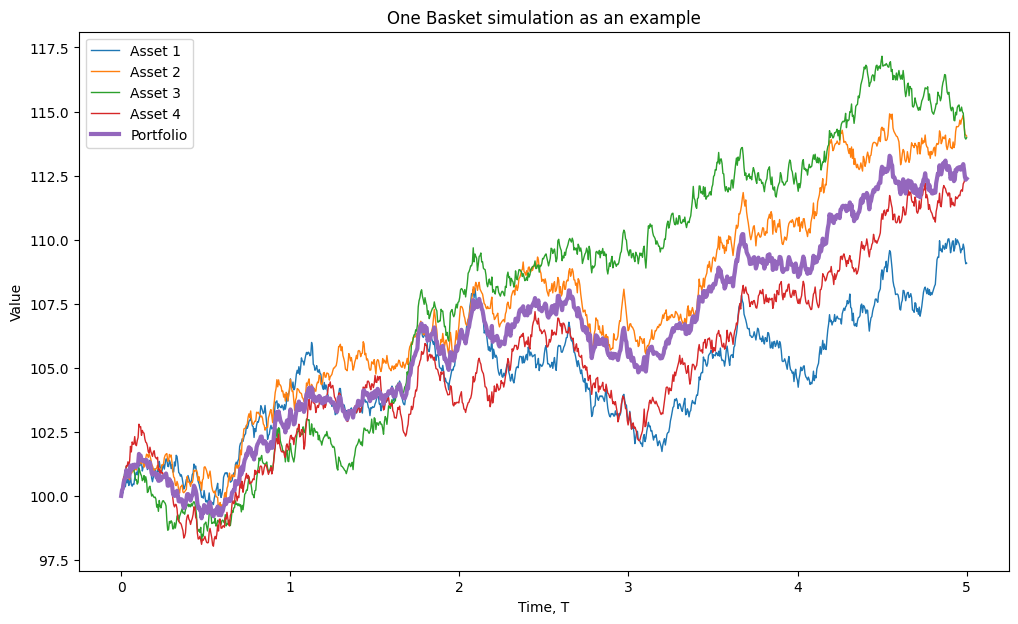

In [16]:
# Пример одной симуляции методом Монте-Карло для равновесной корзины опционов

n_steps = 1000
dt = T / (n_steps - 1)
S_t = np.zeros((n_steps, 4))
S_t[0] = F
COV = sigma.T * rho * sigma
for i in range(n_steps - 1):
    dW = np.random.multivariate_normal(np.zeros(4), COV) * dt
    dS = r * S_t[i] * dt + S_t[i] * dW
    S_t[i + 1] = S_t[i] + dS

plt.figure(figsize=(12, 7))
t_grid = np.linspace(0, T, n_steps)
plt.plot(t_grid, S_t, lw=1, label = [f'Asset {i + 1}' for i in range(N)])
plt.plot(t_grid, S_t @ w, lw=3,  label='Portfolio')
plt.xlabel('Time, T')
plt.ylabel('Value')
plt.title('One Basket simulation as an example')
plt.legend()
plt.show()

In [17]:
# МС оценка для кол и пут опционов
n_steps = 5000
n_sims = 10 ** 3
N_sims = 10 ** 3

dt = T / (n_steps - 1)
COV = sigma.T * rho * sigma

S = np.zeros((n_sims, 4))
S[...] = F

for i in tqdm(range(n_steps - 1)):
    dW = np.random.multivariate_normal(np.zeros(4), COV, size=N_sims) * np.sqrt(dt)
    dS = r * S * dt + S * dW
    S += dS

portfolio_values = S @ w

call_price_mc = np.maximum(portfolio_values - K, 0).mean()
put_price_mc = np.maximum(K - portfolio_values, 0).mean()

print('Call price by Monte-Carlo:', call_price_mc)
print('Put price by Monte-Carlo:', put_price_mc)

100%|██████████| 4999/4999 [00:00<00:00, 7938.26it/s]

Call price by Monte-Carlo: 29.70425766235922
Put price by Monte-Carlo: 28.76442505919182


Пример. Для метода Монте-Карло реализуйте функцию для вычисления стандартного отклонения
$
StdDev = \sqrt{\frac{1}{n}\sum_{i=1}^n(Price - MC\,Price)^2}
$
и постройте доверительный интервал для оценки.

In [18]:
def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  payoff = np.maximum(B_T - K, 0)
  mean = np.mean(payoff) * np.exp(-r * T)
  std = np.std(payoff) * np.exp(-r * T)
  return call_price_mc, std

def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # lower bound of confidence interval for the price
    hi = price + norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # upper bound of confidence interval for the price
    print(f"mean call basket price = {price}, ci: {lo} < price < {hi} with 95% prob")

In [19]:
MC_call, MC_std = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, 4)
CI_MC(MC_call, MC_std, N_mc)

mean call basket price = 29.70425766235922, ci: 29.497313586891327 < price < 29.91120173782711 with 95% prob


### Задача

In [20]:
from scipy.stats import norm, kstest

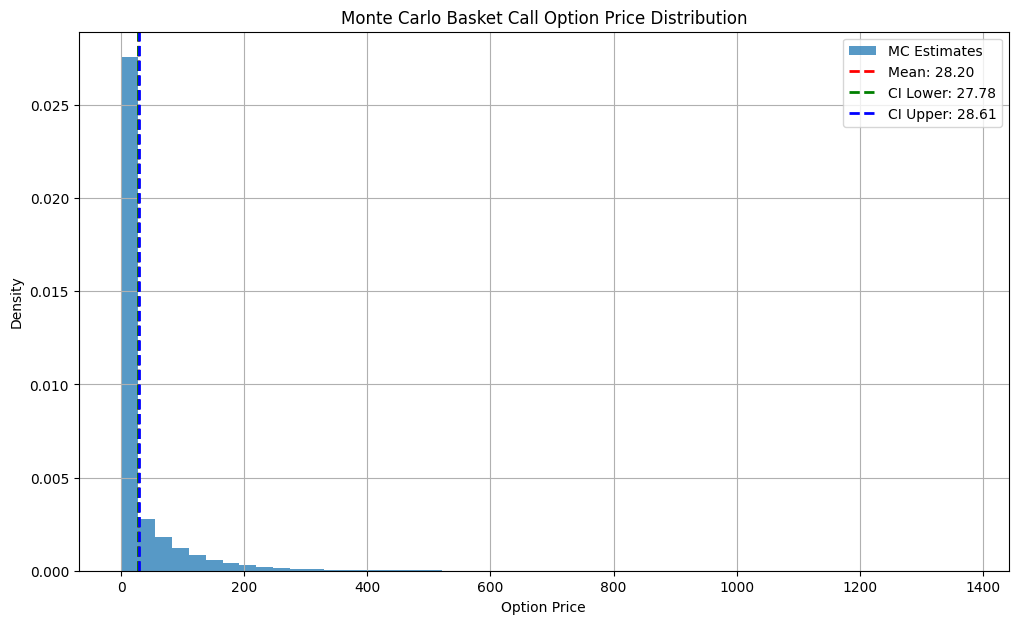

Mean option price: 28.20
Confidence Interval (95%): 27.78 - 28.61
Normality test p-value: 0.0000
Is distribution normal? No


In [21]:
# Function for Monte Carlo with standard deviation
def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
    n = len(w)
    COV = np.outer(sigma, sigma) * rho
    W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
    B_T = np.zeros(N_mc)
    for k in range(n):
        B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:, k]) * w[k]
    payoff = np.maximum(B_T - K, 0)
    mean = np.mean(payoff) * np.exp(-r * T)
    std = np.std(payoff) * np.exp(-r * T)
    return mean, std, payoff

# Confidence interval calculation
def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975) * price_std / np.sqrt(N_mc)
    hi = price + norm.ppf(0.975) * price_std / np.sqrt(N_mc)
    return price, lo, hi

# Parameters
T = 5
r = 0
K = 100
N = 4
rho0 = 0.5
rho = np.ones((N, N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S = np.ones(N) * 100
q = np.zeros(N)
sigma = np.ones(N) * 0.4
w = np.ones(N) / N
N_mc = 10**5

# Monte Carlo simulation
MC_call, MC_std, call_payoff = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc)
MC_mean, CI_lo, CI_hi = CI_MC(MC_call, MC_std, N_mc)

# Plot histogram
plt.figure(figsize=(12, 7))
plt.hist(call_payoff, bins=50, density=True, alpha=0.75, label='MC Estimates')
plt.axvline(MC_mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {MC_mean:.2f}')
plt.axvline(CI_lo, color='g', linestyle='dashed', linewidth=2, label=f'CI Lower: {CI_lo:.2f}')
plt.axvline(CI_hi, color='b', linestyle='dashed', linewidth=2, label=f'CI Upper: {CI_hi:.2f}')
plt.title('Monte Carlo Basket Call Option Price Distribution')
plt.xlabel('Option Price')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

# Hypothesis test for normality
statistic, p_value = kstest(call_payoff, 'norm', args=(MC_mean, MC_std))
is_normal = p_value > 0.05

# Print results
print(f"Mean option price: {MC_mean:.2f}")
print(f"Confidence Interval (95%): {CI_lo:.2f} - {CI_hi:.2f}")
print(f"Normality test p-value: {p_value:.4f}")
print(f"Is distribution normal? {'Yes' if is_normal else 'No'}")

## Исследование влияния параметров модели на оценку стоимости корзины опцинов

Пример.
Проведите исследование влияния параметров (варьировать один параметр, остальные -- зафиксировать) для различных методов аппроксимации и постройте графики, на которых отобразите зависимость для следующих значений параметров:  

* цена страйк $K=\{50, 60, \ldots, 150\}$,
* форвардная цена $F^T=\{50, 60, \ldots, 150\}$,
* корреляция  $\rho=\{0.1, 0.2, \ldots, 0.9, 0.95\}$,
* волатильность $\sigma=\{0.1, 0.2, \ldots, 0.9, 1.0\}$,
* веса $w_1 = \{0.5, 0.2, 0.2, 0.1\}$, $w_2 = \{0.7, 0.1, 0.1, 0.1\}$,
* безрисковая ставка $r=\{0.01, 0.02, 0.05, 0.1\}$.


### Задача.

C:\Users\ciell\AppData\Local\Temp\ipykernel_5616\1800318933.py:11: RuntimeWarning: invalid value encountered in log
  d1 = (m_tilde - np.log(K_star) + v_tilde ** 2) / v_tilde


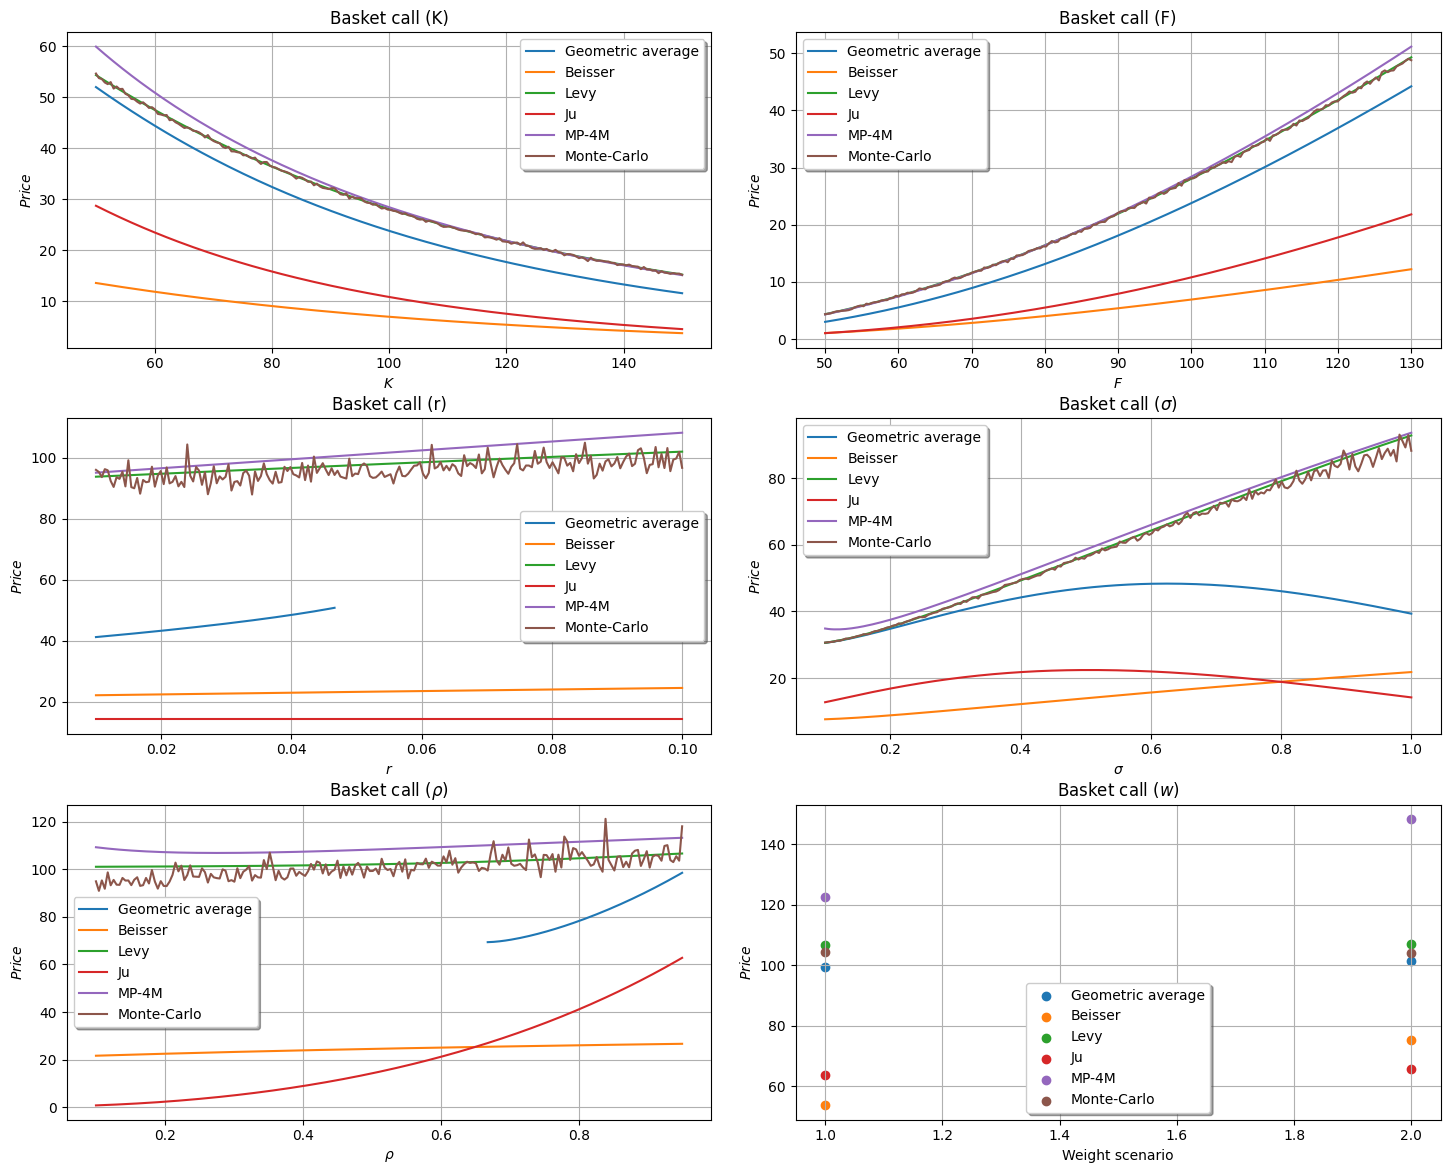

In [22]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 12))
fig.tight_layout(pad=3.0)


'''K research'''
iters = 200
K_data = np.linspace(50, 150, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    geom_avg[i] = geometric_average_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K_data[i], T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    Ju[i] = ju_taylor_approximation_call(S, K_data[i], T, sigma, w, rho)
    MP[i] = Milevsky_Posner_4M_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K_data[i], T, w, r, q, rho, sigma, N_mc)

axs[0][0].plot(K_data, geom_avg, label='Geometric average')
axs[0][0].plot(K_data, Beisser, label='Beisser')
axs[0][0].plot(K_data, Levy, label='Levy')
axs[0][0].plot(K_data, Ju, label='Ju')
axs[0][0].plot(K_data, MP, label='MP-4M')
axs[0][0].plot(K_data, MC, label='Monte-Carlo')
axs[0][0].set_title('Basket call (K)')
axs[0][0].set_xlabel(r'$K$')
axs[0][0].set_ylabel(r'$Price$')
axs[0][0].legend(loc='best', fancybox=True, shadow=True)
axs[0][0].grid(True)

'''F research'''
F_data = np.linspace(50, 130, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    S0 = F_data[i] * np.exp(-r * T)
    S = S0 * np.ones(N)
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
    MP[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

axs[0][1].plot(F_data, geom_avg, label='Geometric average')
axs[0][1].plot(F_data, Beisser, label='Beisser')
axs[0][1].plot(F_data, Levy, label='Levy')
axs[0][1].plot(F_data, Ju, label='Ju')
axs[0][1].plot(F_data, MP, label='MP-4M')
axs[0][1].plot(F_data, MC, label='Monte-Carlo')
axs[0][1].set_title('Basket call (F)')
axs[0][1].set_xlabel(r'$F$')
axs[0][1].set_ylabel(r'$Price$')
axs[0][1].legend(loc='best', fancybox=True, shadow=True)
axs[0][1].grid(True)

'''sigma research'''
sigma_data = np.linspace(0.1, 1.0, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    sigma = np.ones(N) * sigma_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
    MP[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

axs[1][1].plot(sigma_data, geom_avg, label='Geometric average')
axs[1][1].plot(sigma_data, Beisser, label='Beisser')
axs[1][1].plot(sigma_data, Levy, label='Levy')
axs[1][1].plot(sigma_data, Ju, label='Ju')
axs[1][1].plot(sigma_data, MP, label='MP-4M')
axs[1][1].plot(sigma_data, MC, label='Monte-Carlo')
axs[1][1].set_title(r'Basket call ($\sigma$)')
axs[1][1].set_xlabel(r'$\sigma$')
axs[1][1].set_ylabel(r'$Price$')
axs[1][1].legend(loc='best', fancybox=True, shadow=True)
axs[1][1].grid(True)

'''r research'''
r_data = np.linspace(0.01, 0.1, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    r = r_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
    MP[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

axs[1][0].plot(r_data, geom_avg, label='Geometric average')
axs[1][0].plot(r_data, Beisser, label='Beisser')
axs[1][0].plot(r_data, Levy, label='Levy')
axs[1][0].plot(r_data, Ju, label='Ju')
axs[1][0].plot(r_data, MP, label='MP-4M')
axs[1][0].plot(r_data, MC, label='Monte-Carlo')
axs[1][0].set_title(r'Basket call (r)')
axs[1][0].set_xlabel(r'$r$')
axs[1][0].set_ylabel(r'$Price$')
axs[1][0].legend(loc='best', fancybox=True, shadow=True)
axs[1][0].grid(True)

'''rho research'''
rho_data = np.linspace(0.1, 0.95, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    rho = np.ones((N, N)) * rho_data[i] + np.diag(np.ones(N)) * (1 - rho_data[i])
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
    MP[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

axs[2][0].plot(rho_data, geom_avg, label='Geometric average')
axs[2][0].plot(rho_data, Beisser, label='Beisser')
axs[2][0].plot(rho_data, Levy, label='Levy')
axs[2][0].plot(rho_data, Ju, label='Ju')
axs[2][0].plot(rho_data, MP, label='MP-4M')
axs[2][0].plot(rho_data, MC, label='Monte-Carlo')
axs[2][0].set_title(r'Basket call ($\rho$)')
axs[2][0].set_xlabel(r'$\rho$')
axs[2][0].set_ylabel(r'$Price$')
axs[2][0].legend(loc='best', fancybox=True, shadow=True)
axs[2][0].grid(True)

'''w research'''
w_data = np.array([[0.5, 0.2, 0.2, 0.1], [0.7, 0.1, 0.1, 0.1]])
geom_avg = np.zeros(len(w_data))
Beisser = np.zeros(len(w_data))
Levy = np.zeros(len(w_data))
Ju = np.zeros(len(w_data))
MP = np.zeros(len(w_data))
MC = np.zeros(len(w_data))

for i, w in enumerate(w_data):
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, rho)
    MP[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

iterations = range(1, len(w_data) + 1)
axs[2][1].scatter(iterations, geom_avg, label='Geometric average')
axs[2][1].scatter(iterations, Beisser, label='Beisser')
axs[2][1].scatter(iterations, Levy, label='Levy')
axs[2][1].scatter(iterations, Ju, label='Ju')
axs[2][1].scatter(iterations, MP, label='MP-4M')
axs[2][1].scatter(iterations, MC, label='Monte-Carlo')
axs[2][1].set_title(r'Basket call ($w$)')
axs[2][1].set_xlabel('Weight scenario')
axs[2][1].set_ylabel(r'$Price$')
axs[2][1].legend(loc='best', fancybox=True, shadow=True)
axs[2][1].grid(True)

# Показать графики
plt.show()

In [23]:
def pdfs_comparison():
  iters = 100
  S_data = np.linspace(50, 150, iters)
  geom_avg = np.zeros(iters)
  Beisser = np.zeros(iters)
  Levy = np.zeros(iters)
  MP = np.zeros(iters)
  MC = np.zeros(iters)

  for i in range(0, iters):
    S0 = S_data[i]
    S = S0 * np.ones(N)
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, int(10**5))

  plt.plot(S_data, geom_avg, label = 'Gentel')
  plt.plot(S_data, Beisser, label = 'Beisser')
  plt.plot(S_data, Levy, label = 'Levy')
  plt.plot(S_data, MP, label = 'MP-RG')
  plt.plot(S_data, MC, label = r'MC, $N=10^5$')
  plt.title('Basket call')
  plt.xlabel(r'$S_0$')
  plt.legend(loc = 'best', fancybox = True, shadow = True)
  plt.grid(True)

  pdfs_comparison()

# Мини-проект (оценка корзины нейронной сетью)

Оцените корзину европейских опционов с помощью полносвязанной модели нейронной сети.

*  Сгенерируйте цены для $10 000$ опционных корзин, используя одну из аналитических аппроксимаций.
*  Обучите полностью связанную искусственную нейронную сеть для оценки стоиомости опционов.
*  Сравните полученные оценки с Монте-Карло оценками.
Приведите иллюстративные графики.


1. Корзина европейских опционов колл + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M
1. Корзина европейских опционов пут + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M

Option Pricing with Deep Learning

[Отчет](https://cs230.stanford.edu/projects_fall_2019/reports/26260984.pdf) [Постер](https://cs230.stanford.edu/projects_fall_2019/posters/26260929.pdf)
[Пример.](https://github.com/nluciw/pricing_basket_options/blob/main/main_analysis.ipynb)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [25]:
# Define MP-4M approximation for basket call option
def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):
    F = S * np.exp(r * T)
    a = w * F / np.sum(w * F)
    m1 = np.sum(w * F)  # First moment (mean)
    var = (a * sigma).T @ rho @ (a * sigma) * T  # Variance
    std_dev = np.sqrt(var)
    skewness = (np.sum((a * sigma) ** 3) * (T ** 1.5)) / (std_dev ** 3)  # Skewness
    kurtosis = 3 + (np.sum((a * sigma) ** 4) * (T ** 2)) / (var ** 2)  # Kurtosis
    d1 = (np.log(m1 / K) + 0.5 * var) / std_dev
    d2 = d1 - std_dev
    adjustment = (
        1
        + skewness / 6 * (2 * d1 ** 2 + 1)
        + (kurtosis - 3) / 24 * (d1 ** 3 + 3 * d1)
    )
    basket_call = np.exp(-r * T) * (m1 * norm.cdf(d1) - K * norm.cdf(d2)) * adjustment
    return basket_call

Epoch 1/500, Training Loss: 2200.6083984375, Validation Loss: 788.1859130859375
Epoch 2/500, Training Loss: 787.9498901367188, Validation Loss: 155.4123077392578
Epoch 3/500, Training Loss: 154.6680450439453, Validation Loss: 74.01610565185547
Epoch 4/500, Training Loss: 73.59970092773438, Validation Loss: 335.1637268066406
Epoch 5/500, Training Loss: 335.3097229003906, Validation Loss: 404.0601806640625
Epoch 6/500, Training Loss: 404.26959228515625, Validation Loss: 283.62249755859375
Epoch 7/500, Training Loss: 283.52099609375, Validation Loss: 136.5482635498047
Epoch 8/500, Training Loss: 136.2171630859375, Validation Loss: 52.384300231933594
Epoch 9/500, Training Loss: 51.87192153930664, Validation Loss: 41.94964599609375
Epoch 10/500, Training Loss: 41.362083435058594, Validation Loss: 77.49181365966797
Epoch 11/500, Training Loss: 76.90322875976562, Validation Loss: 122.32098388671875
Epoch 12/500, Training Loss: 121.77832794189453, Validation Loss: 147.89093017578125
Epoch 13/5

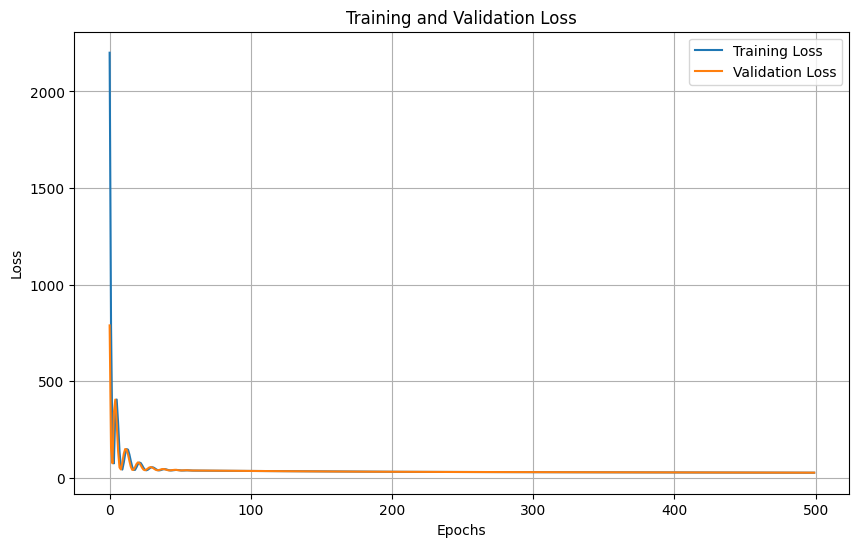

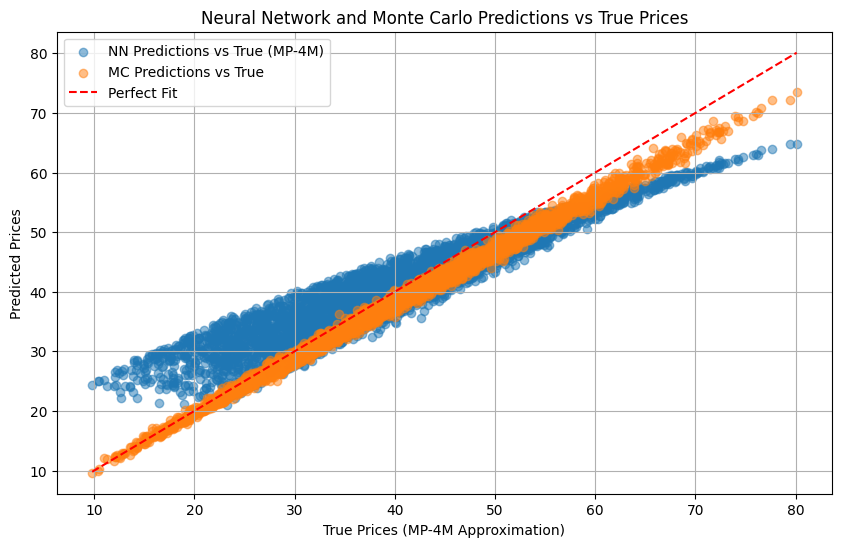

In [26]:
# Parameters for option pricing
N = 4  # Number of assets in the basket
T = 5  # Time to maturity
r = 0.05  # Risk-free rate
sigma = np.ones(N) * 0.4  # Volatility of each asset
rho = 0.5  # Correlation between assets
rho_matrix = np.ones((N, N)) * rho + np.diag(np.ones(N)) * (1 - rho)
w = np.ones(N) / N  # Equal weights for the basket
K = 100  # Strike price
n_samples = 20000  # Number of synthetic samples

# Generate synthetic data for spot prices
np.random.seed(42)
S = np.random.uniform(50, 150, size=(n_samples, N))  # Spot prices for N assets

# Generate target option prices using MP-4M approximation
y_mp4m = np.array([Milevsky_Posner_4M_approximation_basket_call(s, K, T, w, r, rho_matrix, sigma) for s in S])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(S, y_mp4m, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the PyTorch model
class BasketOptionNN(nn.Module):
    def __init__(self):
        super(BasketOptionNN, self).__init__()
        self.fc1 = nn.Linear(N, 129)
        self.fc2 = nn.Linear(129, 311)
        self.fc3 = nn.Linear(311, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.PReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate and train the model
model = BasketOptionNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 500
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_pred = model(X_test)
        val_loss = criterion(val_pred, y_test)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test).numpy()
mse_nn = mean_squared_error(y_test.numpy(), y_pred_nn)
print(f"Mean Squared Error (NN): {mse_nn}")

# Compare with Monte Carlo simulation
def MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc):
    n = len(w)
    COV = np.outer(sigma, sigma) * rho
    W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
    B_T = np.zeros(N_mc)
    for k in range(n):
        B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:, k]) * w[k]
    payoff = np.maximum(B_T - K, 0)
    return np.mean(payoff) * np.exp(-r * T)

N_mc = 10000
y_mc = np.array([MC_basket_call(s, K, T, w, r, np.zeros(N), rho_matrix, sigma, N_mc) for s in X_test.numpy()])
mse_mc = mean_squared_error(y_test.numpy(), y_mc)
print(f"Mean Squared Error (MC): {mse_mc}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Compare Neural Network vs Monte Carlo Pricing
plt.figure(figsize=(10, 6))
plt.scatter(y_test.numpy(), y_pred_nn, alpha=0.5, label='NN Predictions vs True (MP-4M)')
plt.scatter(y_test.numpy(), y_mc, alpha=0.5, label='MC Predictions vs True')
plt.plot([min(y_test.numpy()), max(y_test.numpy())], [min(y_test.numpy()), max(y_test.numpy())], 'r--', label='Perfect Fit')
plt.title('Neural Network and Monte Carlo Predictions vs True Prices')
plt.xlabel('True Prices (MP-4M Approximation)')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()

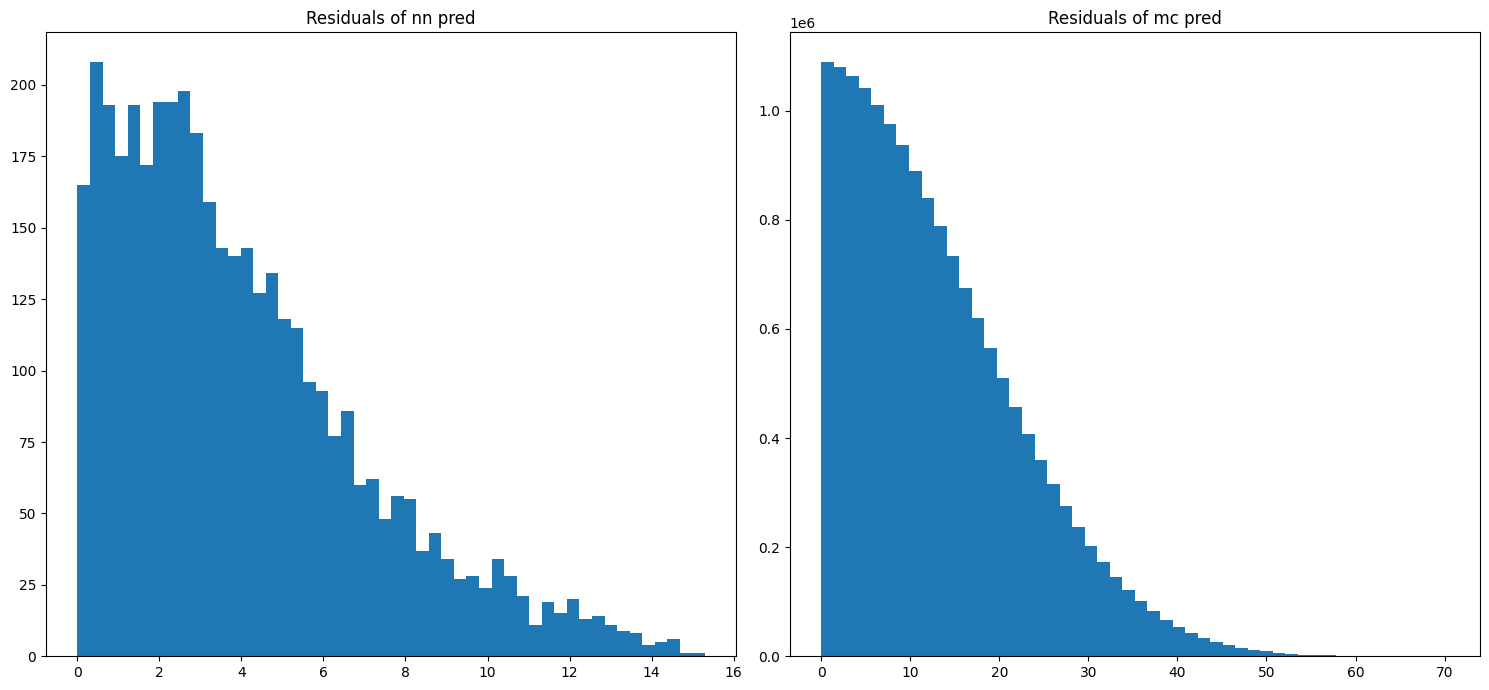

In [37]:
# гистограммы остатков
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].hist(abs(y_test.numpy() - y_pred_nn).reshape(-1), bins=50)
axes[1].hist(abs(y_test.numpy() - y_mc).reshape(-1), bins=50)

axes[0].set_title('Residuals of nn pred')
axes[1].set_title('Residuals of mc pred')

fig.tight_layout()

In [ ]:
# Проверка на гетероскедастичность + обоснование.
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

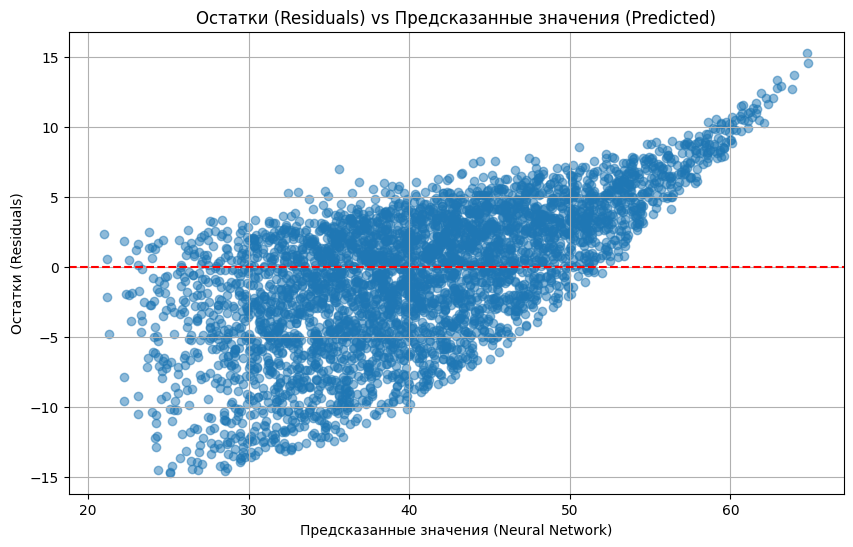

In [42]:
# Остатки модели
residuals_nn = y_test.numpy().flatten() - y_pred_nn.flatten()

# График остатков
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_nn.flatten(), residuals_nn, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки (Residuals) vs Предсказанные значения (Predicted)')
plt.xlabel('Предсказанные значения (Neural Network)')
plt.ylabel('Остатки (Residuals)')
plt.grid(True)
plt.show()

In [ ]:
# Добавление константы к предсказаниям
predicted_nn = sm.add_constant(y_pred_nn.flatten())

# Тест Бреуша-Пагана
bp_test = het_breuschpagan(residuals_nn, predicted_nn)

print("Breusch-Pagan Test Results:")
print(f"LM Statistic: {bp_test[0]}, p-value: {bp_test[1]}")
print(f"F-Statistic: {bp_test[2]}, p-value: {bp_test[3]}")

if bp_test[1] > 0.05:
    print("Нулевая гипотеза (гомоскедастичность) НЕ отвергается. Остатки гомоскедастичны.")
else:
    print("Нулевая гипотеза отвергается. Остатки имеют признаки гетероскедастичности.")

Breusch-Pagan Test Results:
LM Statistic: 20.07050785991993, p-value: 7.463882954209258e-06
F-Statistic: 20.161636175321235, p-value: 7.317245813681645e-06
Нулевая гипотеза отвергается. Остатки имеют признаки гетероскедастичности.


In [49]:
# Тест Уайта
white_test = het_white(residuals_nn, predicted_nn)

print("White Test Results:")
print(f"LM Statistic: {white_test[0]}, p-value: {white_test[1]}")
print(f"F-Statistic: {white_test[2]}, p-value: {white_test[3]}")

if bp_test[1] > 0.05:
    print("Нулевая гипотеза (гомоскедастичность) НЕ отвергается. Остатки гомоскедастичны.")
else:
    print("Нулевая гипотеза отвергается. Остатки имеют признаки гетероскедастичности.")

if white_test[1] > 0.05:
    print("Нулевая гипотеза (гомоскедастичность) НЕ отвергается. Остатки гомоскедастичны.")
else:
    print("Нулевая гипотеза отвергается. Остатки имеют признаки гетероскедастичности.")

White Test Results:
LM Statistic: 664.7285960630982, p-value: 4.529177938908271e-145
F-Statistic: 398.30644596538934, p-value: 1.8229316548920133e-158
Нулевая гипотеза отвергается. Остатки имеют признаки гетероскедастичности.
Нулевая гипотеза отвергается. Остатки имеют признаки гетероскедастичности.


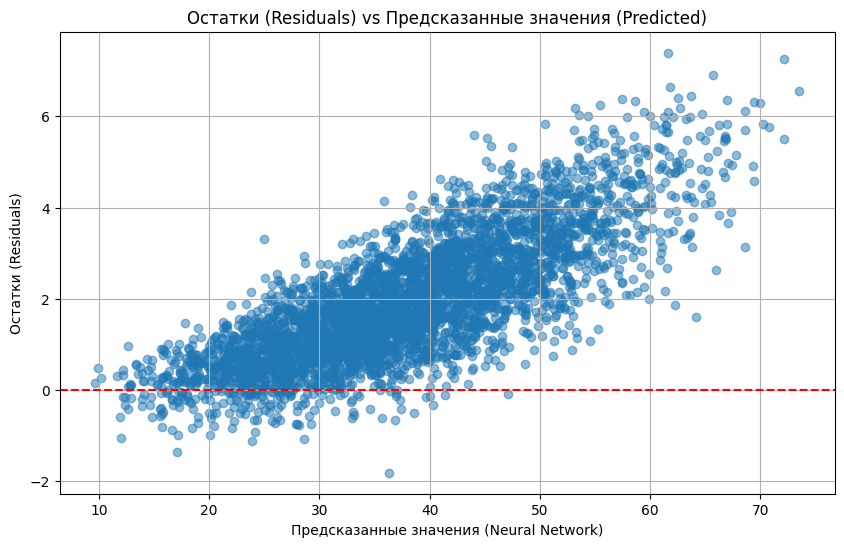

In [45]:
# Остатки модели
residuals_mc = y_test.numpy().flatten() - y_mc.flatten()

# График остатков
plt.figure(figsize=(10, 6))
plt.scatter(y_mc.flatten(), residuals_mc, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки (Residuals) vs Предсказанные значения (Predicted)')
plt.xlabel('Предсказанные значения (Neural Network)')
plt.ylabel('Остатки (Residuals)')
plt.grid(True)
plt.show()

In [50]:
# Добавление константы к предсказаниям
predicted_mc = sm.add_constant(y_mc.flatten())

# Тест Бреуша-Пагана
bp_test = het_breuschpagan(residuals_mc, predicted_mc)

print("Breusch-Pagan Test Results:")
print(f"LM Statistic: {bp_test[0]}, p-value: {bp_test[1]}")
print(f"F-Statistic: {bp_test[2]}, p-value: {bp_test[3]}")

if bp_test[1] > 0.05:
    print("Нулевая гипотеза (гомоскедастичность) НЕ отвергается. Остатки гомоскедастичны.")
else:
    print("Нулевая гипотеза отвергается. Остатки имеют признаки гетероскедастичности.")


Breusch-Pagan Test Results:
LM Statistic: 2093.2627026575437, p-value: 0.0
F-Statistic: 4389.101895100647, p-value: 0.0
Нулевая гипотеза отвергается. Остатки имеют признаки гетероскедастичности.


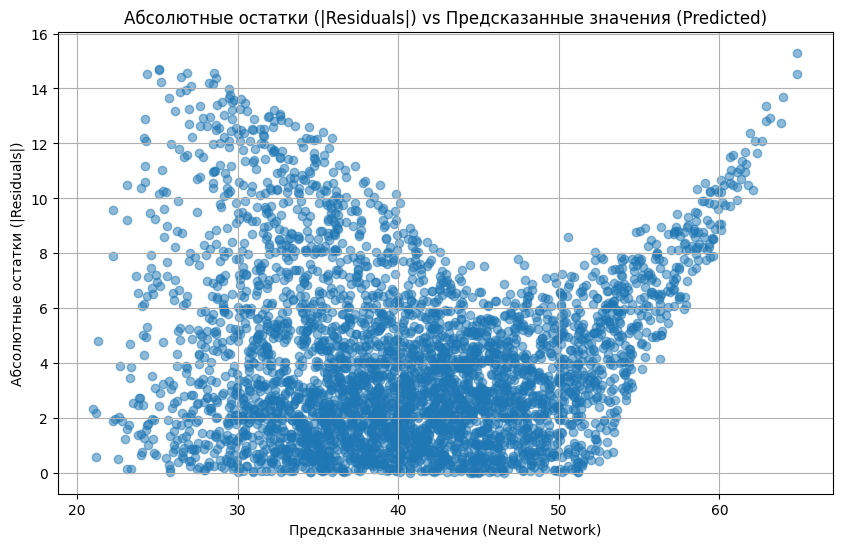

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_nn.flatten(), np.abs(residuals_nn), alpha=0.5)
plt.title('Абсолютные остатки (|Residuals|) vs Предсказанные значения (Predicted)')
plt.xlabel('Предсказанные значения (Neural Network)')
plt.ylabel('Абсолютные остатки (|Residuals|)')
plt.grid(True)
plt.show()